In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
train_df = pd.read_csv('clean_data.csv')
val_df = pd.read_csv('clean_val.csv')
test_df = pd.read_csv('clean_test.csv')

In [3]:
train_df.dropna(inplace = True)

In [4]:
with open("numerical.txt", "r", encoding="utf-8") as file:
    numeric_features = [line.strip() for line in file.readlines()]
    
with open("cat.txt", "r", encoding="utf-8") as file:
    cat_features = [line.strip() for line in file.readlines()]


In [5]:
print('Total number of Numerical Features and one target:', len(numeric_features))
print('Total number of Categorical Features:',len(cat_features))

Total number of Numerical Features and one target: 9
Total number of Categorical Features: 70


# Load Machine Learning Library

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lambdas_ = {}

    def fit(self, X, y=None):
        X = X.copy()
        for column in X.columns:
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            _, lambda_optimal = stats.boxcox(X[column])
            self.lambdas_[column] = lambda_optimal
        return self

    def transform(self, X):
        X = X.copy()
        for column, lambda_optimal in self.lambdas_.items():
            if any(X[column] <= 0):
                X[column] = X[column] + abs(X[column].min()) + 1
            X[column] = stats.boxcox(X[column], lmbda=lambda_optimal)
        return X


In [8]:
lg = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

xgb = XGBRegressor()
lgm = LGBMRegressor()
cat = CatBoostRegressor()

models = [('lg', lg), ('ridge', ridge), ('lasso', lasso), ('elastic', elastic), ('xgb', xgb), ('lgm', lgm),('cat', cat)]

In [9]:
train_X = train_df[numeric_features + cat_features]
train_y = train_df['price']

val_X = val_df[numeric_features + cat_features]
val_y = val_df['price']

test_X = test_df[numeric_features + cat_features]
test_y = test_df['price']


In [10]:
numeric_transformer = Pipeline([
    ('boxcox', BoxCoxTransformer()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)


In [11]:
from tqdm import tqdm

def rmse(y, y_predict):
    mse = mean_squared_error(y, y_predict)
    return math.sqrt(mse)

def evaluate_models(model):
    results = []

    for name, model in tqdm(model, desc="Evaluating Models"):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regression', model)
        ])
        
        pipeline.fit(train_X, train_y)
        
        val_predict = pipeline.predict(val_X)
        
        val_mae = mean_absolute_error(val_y, val_predict)
        val_rmse = rmse(val_y, val_predict)
        
        
        test_predict = pipeline.predict(test_X)
        test_mae = mean_absolute_error(test_y, test_predict)
        test_rmse = rmse(test_y, test_predict)
       
        results.append({
            'model': name,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
        })
    
    return results

# Evalute Result

In [12]:
res = evaluate_models(models)

Evaluating Models:  71%|██████████████████████████████████████████████▍                  | 5/7 [00:08<00:02,  1.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 17941, number of used features: 302
[LightGBM] [Info] Start training from score 134.868792


Evaluating Models:  86%|███████████████████████████████████████████████████████▋         | 6/7 [00:09<00:01,  1.19s/it]

Learning rate set to 0.064608
0:	learn: 99.0332913	total: 143ms	remaining: 2m 23s
1:	learn: 96.4810982	total: 151ms	remaining: 1m 15s
2:	learn: 94.1693781	total: 159ms	remaining: 52.8s
3:	learn: 92.0574061	total: 166ms	remaining: 41.4s
4:	learn: 90.3081270	total: 173ms	remaining: 34.4s
5:	learn: 88.5195452	total: 180ms	remaining: 29.9s
6:	learn: 86.9758231	total: 187ms	remaining: 26.6s
7:	learn: 85.6218836	total: 195ms	remaining: 24.1s
8:	learn: 84.2632248	total: 203ms	remaining: 22.3s
9:	learn: 83.0512368	total: 211ms	remaining: 20.8s
10:	learn: 81.9781469	total: 218ms	remaining: 19.6s
11:	learn: 81.0236835	total: 226ms	remaining: 18.6s
12:	learn: 80.1803127	total: 234ms	remaining: 17.8s
13:	learn: 79.3880886	total: 242ms	remaining: 17s
14:	learn: 78.6621519	total: 249ms	remaining: 16.4s
15:	learn: 78.0584278	total: 257ms	remaining: 15.8s
16:	learn: 77.4389586	total: 265ms	remaining: 15.3s
17:	learn: 76.9101017	total: 272ms	remaining: 14.9s
18:	learn: 76.3761382	total: 280ms	remaining

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.54s/it]


In [13]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
6,cat,48.923889,274.947126,45.435616,135.675032
4,xgb,49.376936,275.069624,45.575750,133.513682
5,lgm,49.372014,274.327459,45.701704,137.234545
1,ridge,60.019968,281.377948,55.852781,150.701109
0,lg,60.393103,281.495912,56.002050,150.388048
2,lasso,60.701732,282.314485,56.833592,153.526881
3,elastic,62.645983,283.375987,58.135126,156.171288


# Fine Tunning using Optuna

In [16]:
import optuna

def objective(trial):

    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.05)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    n_estimators = trial.suggest_int('n_estimators', 1000, 2000)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 5.0, 15.0)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    boosting_type = trial.suggest_categorical('boosting_type', ['Plain', 'Ordered'])
    
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        colsample_bylevel=colsample_bylevel,
        boosting_type=boosting_type,
        random_state=42,
        logging_level='Silent'
    )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [17]:
study1 = optuna.create_study(direction='minimize')
study1.optimize(objective, n_trials=50) 

[I 2024-11-17 16:34:48,410] A new study created in memory with name: no-name-b13a3e86-e011-4b5b-8257-2070d8d74a2f
[I 2024-11-17 16:34:54,177] Trial 0 finished with value: 51.990949578996045 and parameters: {'learning_rate': 0.03071169998037284, 'max_depth': 3, 'n_estimators': 1437, 'l2_leaf_reg': 13.550029542203463, 'subsample': 0.8050102768225373, 'colsample_bylevel': 0.6167043279574634, 'boosting_type': 'Plain'}. Best is trial 0 with value: 51.990949578996045.
[I 2024-11-17 16:35:17,153] Trial 1 finished with value: 50.50553289637071 and parameters: {'learning_rate': 0.034122435580747144, 'max_depth': 5, 'n_estimators': 1415, 'l2_leaf_reg': 7.0225537675217105, 'subsample': 0.9357003779204701, 'colsample_bylevel': 0.8175573610458862, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 50.50553289637071.
[I 2024-11-17 16:35:27,059] Trial 2 finished with value: 50.18574313202511 and parameters: {'learning_rate': 0.020852035851211766, 'max_depth': 5, 'n_estimators': 1728, 'l2_leaf_r

In [18]:
cat_best_param = study1.best_trial.params
print("Best trial for CatBoostRegressor:")
print(study1.best_trial.params)
print("Best Validation MAE:", study1.best_value)

Best trial for CatBoostRegressor:
{'learning_rate': 0.04818703147093649, 'max_depth': 6, 'n_estimators': 1943, 'l2_leaf_reg': 5.5306328957544055, 'subsample': 0.7938620424195088, 'colsample_bylevel': 0.7127428088947894, 'boosting_type': 'Plain'}
Best Validation MAE: 48.59353327594986


In [19]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 1000, 2000)
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = LGBMRegressor(
                learning_rate=learning_rate,
                max_depth=max_depth,
                n_estimators=n_estimators,
                num_leaves=num_leaves,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                verbosity=-1,
                random_state=42
            )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [20]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=50) 

[I 2024-11-17 16:48:20,604] A new study created in memory with name: no-name-5a9e623c-f1d0-4653-b5df-045623994110
[I 2024-11-17 16:48:24,271] Trial 0 finished with value: 48.347975752096986 and parameters: {'learning_rate': 0.02368934204910208, 'max_depth': 10, 'n_estimators': 1850, 'num_leaves': 78, 'subsample': 0.9140785005689738, 'colsample_bytree': 0.7717792684911974}. Best is trial 0 with value: 48.347975752096986.
[I 2024-11-17 16:48:27,411] Trial 1 finished with value: 48.41988827070125 and parameters: {'learning_rate': 0.01956293965204379, 'max_depth': 9, 'n_estimators': 1961, 'num_leaves': 49, 'subsample': 0.9903146384388402, 'colsample_bytree': 0.6631880303020231}. Best is trial 0 with value: 48.347975752096986.
[I 2024-11-17 16:48:28,858] Trial 2 finished with value: 49.66604297096467 and parameters: {'learning_rate': 0.028947821415182887, 'max_depth': 5, 'n_estimators': 1326, 'num_leaves': 63, 'subsample': 0.7343453369189217, 'colsample_bytree': 0.6739277307042494}. Best is

In [21]:
lgbm_best_param = study2.best_trial.params
print("Best trial for LightBoostRegressor:")
print(study2.best_trial.params)
print("Best Validation MAE:", study2.best_value)

Best trial for LightBoostRegressor:
{'learning_rate': 0.018200449303492686, 'max_depth': 10, 'n_estimators': 1894, 'num_leaves': 150, 'subsample': 0.926693424000662, 'colsample_bytree': 0.6042415303434234}
Best Validation MAE: 47.972660563655936


In [22]:
def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.03)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    n_estimators = trial.suggest_int('n_estimators', 1000, 2000)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    alpha =  trial.suggest_loguniform('alpha', 1e-8, 10.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 1.0)
    
    model = XGBRegressor(
                learning_rate=learning_rate,
                max_depth=max_depth,
                n_estimators=n_estimators,
                subsample=subsample,
                alpha = alpha,
                colsample_bytree = colsample_bytree,
                random_state=42
            )
    
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regression', model)
        ])
  
    pipeline.fit(train_X, train_y)
        
    val_predict = pipeline.predict(val_X)

    val_mae = mean_absolute_error(val_y, val_predict)
    val_rmse = rmse(val_y, val_predict)
    
    return val_mae

In [23]:
study3 = optuna.create_study(direction='minimize')
study3.optimize(objective, n_trials=50) 

[I 2024-11-17 16:50:52,481] A new study created in memory with name: no-name-96baa7f7-953d-499b-8621-f41fd8895f0c
[I 2024-11-17 16:51:09,946] Trial 0 finished with value: 47.915999297862186 and parameters: {'learning_rate': 0.024071620353686603, 'max_depth': 9, 'n_estimators': 1700, 'subsample': 0.7053170823306615, 'alpha': 0.8796383509092539, 'colsample_bytree': 0.8295092457179181}. Best is trial 0 with value: 47.915999297862186.
[I 2024-11-17 16:51:26,495] Trial 1 finished with value: 47.553292144788735 and parameters: {'learning_rate': 0.020914858745575554, 'max_depth': 9, 'n_estimators': 1914, 'subsample': 0.9924226684321888, 'alpha': 4.472742116717665e-05, 'colsample_bytree': 0.7417845401827614}. Best is trial 1 with value: 47.553292144788735.
[I 2024-11-17 16:51:39,598] Trial 2 finished with value: 47.621498418990626 and parameters: {'learning_rate': 0.021212062345897863, 'max_depth': 10, 'n_estimators': 1266, 'subsample': 0.6592021834684909, 'alpha': 0.031312777715192024, 'colsa

In [24]:
xgb_best_param = study3.best_trial.params
print("Best trial for XGBRegressor:")
print(study3.best_trial.params)
print("Best Validation MAE:", study3.best_value)

Best trial for XGBRegressor:
{'learning_rate': 0.023132876025388348, 'max_depth': 9, 'n_estimators': 1818, 'subsample': 0.8773658332333665, 'alpha': 0.002064033728197955, 'colsample_bytree': 0.4365747939159745}
Best Validation MAE: 47.066077512166466


In [25]:
best_xgb = XGBRegressor(**xgb_best_param)
best_lgm = LGBMRegressor(**lgbm_best_param)
best_cat = CatBoostRegressor(**cat_best_param)

best_models = [('cat', best_cat), ('lgm', best_lgm), ('xgb', best_xgb)]

In [26]:
res = evaluate_models(best_models)

Evaluating Models:   0%|                                                                         | 0/3 [00:00<?, ?it/s]

0:	learn: 99.7399289	total: 6.88ms	remaining: 13.4s
1:	learn: 97.8482973	total: 14.5ms	remaining: 14.1s
2:	learn: 96.0362441	total: 22.2ms	remaining: 14.4s
3:	learn: 94.3144401	total: 29.3ms	remaining: 14.2s
4:	learn: 92.7611024	total: 37.1ms	remaining: 14.4s
5:	learn: 91.2999477	total: 44.5ms	remaining: 14.4s
6:	learn: 89.9912373	total: 52.2ms	remaining: 14.4s
7:	learn: 88.7963006	total: 59.7ms	remaining: 14.4s
8:	learn: 87.7073621	total: 67.1ms	remaining: 14.4s
9:	learn: 86.5865317	total: 74.2ms	remaining: 14.3s
10:	learn: 85.5498253	total: 81.2ms	remaining: 14.3s
11:	learn: 84.6193934	total: 88.5ms	remaining: 14.2s
12:	learn: 83.8337360	total: 96ms	remaining: 14.2s
13:	learn: 82.9956736	total: 103ms	remaining: 14.2s
14:	learn: 82.2373778	total: 111ms	remaining: 14.2s
15:	learn: 81.5465797	total: 118ms	remaining: 14.2s
16:	learn: 80.8699834	total: 125ms	remaining: 14.2s
17:	learn: 80.2680914	total: 133ms	remaining: 14.2s
18:	learn: 79.6993633	total: 140ms	remaining: 14.2s
19:	learn: 

Evaluating Models:  33%|█████████████████████▋                                           | 1/3 [00:15<00:30, 15.06s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 17941, number of used features: 302
[LightGBM] [Info] Start training from score 134.868792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Evaluating Models: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.91s/it]


In [27]:
res_df = pd.DataFrame(res)
res_df.sort_values(by = 'test_mae')

,model,val_mae,val_rmse,test_mae,test_rmse
2,xgb,47.183259,273.936949,44.115572,138.236509
1,lgm,48.261680,273.301676,44.589038,135.964479
0,cat,48.701379,274.772487,45.052875,134.889378


The best model, using only numerical and categorical features, is the fine-tuned XGB, which achieved a testing MAE of 44.36 and a testing RMSE of 138.54.

# Using XGB for feature importance

In [30]:
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == "drop":
            continue
        elif transformer == "passthrough":
            feature_names.extend(columns if isinstance(columns, list) else [columns])
        else:
            try:
                feature_names.extend(transformer.get_feature_names_out(columns))
            except AttributeError:
                feature_names.extend(columns if isinstance(columns, list) else [columns])
    return feature_names

In [31]:


preprocessor.fit(train_X)

final_feature_names = get_feature_names_from_column_transformer(preprocessor)


model = XGBRegressor(**xgb_best_param)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', model)
])


pipeline.fit(train_X, train_y)

xgb_model = pipeline.named_steps['regression']

importances = xgb_model.feature_importances_


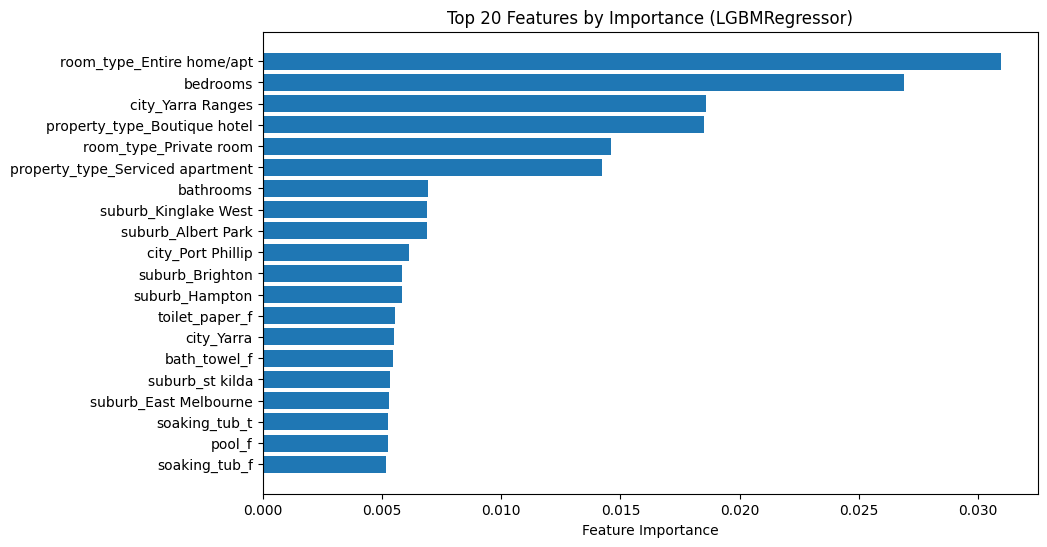

In [32]:
feature_importance_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Importance (LGBMRegressor)")
plt.show()